# ICML 2020. Paper XXX 


Load package with the algorithms and ML models

In [ ]:
] activate ../../Acceleration

Select the dataset and ML models. The ML model returns the functions and constants required by the algorithms (i.e., objective evaluation, compute gradients, smoothness parameters, etc.)

In [ ]:
using Acceleration
using LinearAlgebra

data, labels = load_libsvm_dataset("mushrooms",500); # dataset name (a5a, mushrooms), num samples
f,∇f,∇ϕ_cjg,σ,L,μ  = logistic_regression(data,labels,1);

## Experiement A. Convergence with exact gradients.
 The convergence rate of our algorithm is:

\begin{align}
\! \! f(y_k) - f^\star \le \frac{2ML}{\sigma } \prod_{i=1}^k \left(1 + \max \left\{ \frac{2}{i}, \sqrt \frac{\mu}{L} \right\} \right)^{-1}
\label{eq:accelerated_bound}
\end{align}
where $\sigma$, $M$, and $L$ are constants. Constants $\mu$ and $L$ depend on the strong convexity and smootheness of the objective function. This experiment shows the behavior of our algorithm (i.e., how it transitions from sublinear rate ($1/k^2$) to linear rate) and compares its performance to state-of-the-art algorithms.

### Simulation

In [ ]:
d,n = size(data)
x_ini = zeros(n)
k = 2000;
μ = 1
L = 500
ω = 0; 

function exact_gradient(x)
    return ∇f(x), 0
end

grad_fun = exact_gradient

@time f_opt = ufom(f,exact_gradient,∇ϕ_cjg,x_ini,σ,L,μ,2*k,Inf)[end]

@time p1 = MD(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt;
@time p2 = PGD_avg(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt;
@time p3 = ufom(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,μ,k,5) .- f_opt; # Our algorithm
@time p4 = AMD_plus(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt;
@time p5 = μAMD_plus(f,grad_fun,∇ϕ_cjg,x_ini,L,μ,k) .- f_opt;
#@time p6 = ACGD(f,grad_fun,x_ini,L,k,ω) .- f_opt;
@time p7 = μACGD(f,grad_fun,x_ini,L,μ,k,ω) .- f_opt;
@time p8 = Nesterov83(f,grad_fun,x_ini,k) .- f_opt;

In [ ]:
using Plots

fig = plot(max.(hcat(p1,p2,p3,p4,p5,p7,p8),1e-8),yaxis=:log, linewidth=2, legend=:topright,
label = ["Mirror-descent" "Gradient-descent (avg)" "New Algorithm" "AMD+ (ICML 2018)" "μAMD+ (ICML 2018)" "ACGD (ICML 2020)" "AGD (Nesterov)"], xlabel = "Training rounds", ylabel = "Loss")

## Experiment B
Convergence with gradient compression schemes. Recall that

\begin{align}
\widetilde \nabla f(x_k)  = \nabla f(x_k) + \xi_k
\end{align}
where $\xi_k \in \mathbf R^n$ and $\mathbb E[\xi_k] = 0$. In Federeated Learning, $\widetilde \nabla f(x_k)$ is the aggregate of all the clients' noisy graients.

### Gradient Compression Functions

In [ ]:
function exact_gradient(x)
    return ∇f(x), 0
end

function noisy_gradient(x)
    n = size(x,1);
    ξ = 1; 
    noise = randn(n);
    noise = noise / norm(noise,2);
    noise = noise*ξ;
    return (∇f(x) + noise), ξ;
end

function binary(x)
    η = -∇f(x) + sign.(∇f(x)) .* (abs.(∇f(x)) .> norm(∇f(x),Inf)/2) .* norm(∇f(x),Inf)/2;
    return ∇f(x) + η, norm(η,2)
end

function random_sparsification(x)
    grad = ∇f(x)
    n = size(grad,1)
    r = 1/4
    mask = Float64.(rand(n) .< r)
    rs_gradient = (1/r)*grad.*mask
    return rs_gradient, norm(rs_gradient,2)
end

function random_sparsification_no_memory(x)
    grad = ∇f(x)
    n = size(grad,1)
    k = Int16.(ceil(n/4));
    sorted_vector = sort(abs.(grad))
    k_largest = sorted_vector[n-k+1]
    mask = Int16.(abs.(grad) .> k_largest)
    rs_gradient = grad.*mask;
    return rs_gradient, norm(rs_gradient,2)
end

function dithering(x)
    q = Inf;
    grad = ∇f(x)
    n = size(grad,1)
    levels = 10;
    leveled_gradient = sign.(grad).*(levels/norm(grad,q)).*grad/2
    base = floor.(leveled_gradient)
    rv = Float64.(rand(n) .> (leveled_gradient .- floor.(leveled_gradient)))
    quantized_gradient = sign.(grad).*(base .+ rv)*norm(grad,q)/levels*2;
    
    return quantized_gradient, norm(quantized_gradient,2)
end

function natural_compression(x)

    grad = ∇f(x)
    n = size(grad,1)
    nat_grad = sign.(grad).*2.0.^(floor.(log2.(abs.(grad)))).*(1 .+ rand(n))
    
    return nat_grad, norm(nat_grad,2)
end

### Simulation

In [ ]:
d,n = size(data)
x_ini = zeros(n)
k = 2000;
μ = 1
L = 500
ω = 0; 

function exact_gradient(x)
    return ∇f(x), 0
end

grad_fun = noisy_gradient

@time f_opt = ufom(f,exact_gradient,∇ϕ_cjg,x_ini,σ,L,μ,2*k,Inf)[end]

@time p1 = MD(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt;
@time p2 = PGD_avg(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt;
@time p3 = ufom(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,μ,k,Inf) .- f_opt; # Our algorithm
@time p4 = AMD_plus(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt;
@time p5 = μAMD_plus(f,grad_fun,∇ϕ_cjg,x_ini,L,μ,k) .- f_opt;
#@time p6 = ACGD(f,grad_fun,x_ini,L,k,ω) .- f_opt;
@time p7 = μACGD(f,grad_fun,x_ini,L,μ,k,ω) .- f_opt;
@time p8 = Nesterov83(f,grad_fun,x_ini,k) .- f_opt;

In [ ]:
fig = plot(max.(min.(hcat(p1,p2,p3,p4,p5,p7),1e3),1e-16),yaxis=:log, linewidth=2, legend=:topright,
label = ["Mirror-descent" "Gradient-descent (avg)" "New Algorithm" "AMD+ (ICML 2018)" "μAMD+ (ICML 2018)" "ACGD (ICML 2020)" "AGD (Nesterov)"], title=grad_fun, xlabel = "Bits transmitted", ylabel = "f(y)-f^*")

## Experiment C. Us vs. ICML 2020

This experiment compares the proposed algorithm to:


Li, Z., Kovalev, D., Qian, X. &amp; Richtarik, P.. (2020). Acceleration for Compressed Gradient Descent in Distributed and Federated Optimization. <i>Proceedings of the 37th International Conference on Machine Learning</i>, in <i>Proceedings of Machine Learning Research</i> 119:5895-5904 Available from 
http://proceedings.mlr.press/v119/li20g.html

The simulation results are saved in text files. The plots can be generated using gnuplot with the following command:
```
gnuplot plots.gp
```
The script is in the "notes" folder, and the plots are the the folder "figures."


In [ ]:
using Acceleration
using LinearAlgebra

for model in ["mushrooms"]
    
    data, labels = load_libsvm_dataset(model,1000); # dataset name (a5a, mushrooms), num samples
    f,∇f,∇ϕ_cjg,σ,L,μ  = logistic_regression(data,labels,1);

    d,n = size(data)
    x_ini = zeros(n)
    k = 2000;
    μ = 0.1
    L = 200
    if(model=="a5a")
        L = 1000;
    end
    ω = 0;


    @time f_opt = ufom(f,exact_gradient,∇ϕ_cjg,x_ini,σ,L,μ,2*k,Inf)[end]

    @time for grad_fun in [exact_gradient,random_sparsification, dithering, natural_compression]

        p3 = max.(1e-12,ufom(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,μ,k,Inf) .- f_opt);
        p4 = max.(1e-12,AMD_plus(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt);
        p7 = max.(1e-12,μACGD(f,grad_fun,x_ini,L,μ,k,ω) .- f_opt);
    
        filename = string("logs/",model,"_",grad_fun,".txt")
        io = open(filename, "w")
        
        if(grad_fun==exact_gradient)
            bits = n*64;
        elseif(grad_fun==random_sparsification)
            bits = (n/4)*64;
        elseif(grad_fun==dithering)
            bits = 2.8*n + 64;
        elseif(grad_fun==natural_compression)
            bits = n*9;
        end
        
        for i=1:k
            print(io,i)
            print(io,"\t")
            print(io,i*n*64)
            print(io,"\t")
            print(io,i*bits)
            print(io,"\t")
            print(io, p7[i])
            print(io,"\t")
            print(io, p4[i])
            print(io,"\t")
            print(io, p3[i])
            print(io,"\n")
        end
        close(io)
    end
end

## Experiment D. Quadratic
This experiment combines experiement A and B. I'm still polishing it. 

In [1]:
] activate ../../Acceleration

 Activating environment at `~/Desktop/Code/Acceleration/Acceleration/Project.toml`


  0.117906 seconds (15.51 k allocations: 61.222 MiB)
  0.384141 seconds (293.83 k allocations: 560.705 MiB, 5.55% gc time)
  0.407616 seconds (288.00 k allocations: 560.421 MiB, 4.87% gc time)
  0.479133 seconds (449.60 k allocations: 618.882 MiB, 6.03% gc time)
  0.393799 seconds (349.95 k allocations: 582.414 MiB, 5.94% gc time)
  0.432591 seconds (436.87 k allocations: 618.197 MiB, 6.86% gc time)
  0.393494 seconds (395.29 k allocations: 597.023 MiB, 6.46% gc time)
  0.386193 seconds (396.79 k allocations: 597.084 MiB, 7.43% gc time)
  0.394021 seconds (419.31 k allocations: 565.868 MiB, 4.42% gc time)
  0.386175 seconds (449.63 k allocations: 618.883 MiB, 6.87% gc time)
  0.108090 seconds (15.51 k allocations: 61.222 MiB, 3.63% gc time)
  0.345414 seconds (259.50 k allocations: 558.923 MiB, 5.62% gc time)
  0.333891 seconds (259.50 k allocations: 558.923 MiB, 4.93% gc time)
  0.380569 seconds (389.50 k allocations: 615.840 MiB, 7.71% gc time)
  0.354514 seconds (309.50 k allocation

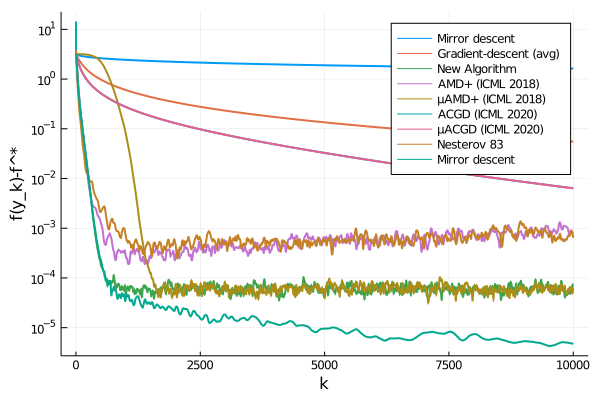

In [8]:
using Acceleration
using LinearAlgebra
using Plots

m = 100;
n = 75;

f,∇f,∇ϕ_cjg,σ,L,μ  = rand_psd(m,n);

k = 10000
x_ini = zeros(n)
ω = 0;

function exact_gradient(x)
    return ∇f(x), 0
end

function noisy_gradient(x)
    n = size(x,1);
    ξ = 0.1; 
    noise = randn(n);
    noise = noise / norm(noise,2);
    noise = noise*ξ;
    return (∇f(x) + noise), ξ;
end

function noisy_gradient2(x)
    n = size(x,1);
    ξ = 1; 
    noise = randn(n);
    noise = noise / norm(noise,2);
    noise = noise*ξ;
    return (∇f(x) + noise), ξ;
end

for j=1:2

    @time f_opt = f(rand_psd_compute_optval(f,n));#ufom(f,exact_gradient,∇ϕ_cjg,x_ini,σ,L,μ,10*k,Inf,false)[end]
    grad_fun = noisy_gradient

    @time p1 = MD(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt;
    @time p2 = PGD_avg(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt;
    @time p3 = ufom(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,μ,k,Inf) .- f_opt;
    @time p4 = AMD_plus(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt;
    @time p5 = μAMD_plus(f,grad_fun,∇ϕ_cjg,x_ini,L,μ,k) .- f_opt;
    @time p6 = ACGD(f,grad_fun,x_ini,L,k,ω) .- f_opt;
    @time p7 = μACGD(f,grad_fun,x_ini,L,μ,k,ω) .- f_opt;
    @time p8 = Nesterov83(f,grad_fun,x_ini,k) .- f_opt;
    @time p9 = ufom(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,μ,k,5) .- f_opt;
    
    p1_avg = (1-1/j)*p1_avg + (1/j)*p1;
    
end


fig = plot(max.(min.(hcat(p1,p2,p3,p4,p5,p6,p7,p8,p9),1e3),1e-12),yaxis=:log, linewidth=2, legend=:topright,label = ["Mirror descent" "Gradient-descent (avg)" "New Algorithm" "AMD+ (ICML 2018)" "μAMD+ (ICML 2018)" "ACGD (ICML 2020)" "μACGD (ICML 2020)" "Nesterov 83"], xlabel = "k", ylabel = "f(y_k)-f^*")

In [17]:
@time for grad_fun in [exact_gradient,noisy_gradient,noisy_gradient2]
    p1 = zeros(k)
    p2 = zeros(k)
    p3 = zeros(k)
    p4 = zeros(k)
    p5 = zeros(k)
    p6 = zeros(k)
    p7 = zeros(k)
    p8 = zeros(k)
    p9 = zeros(k)
    
    samples = 50
    for j=1:samples
            
        @time p1 = (1-1/j).*p1 .+ (1/j).*max.(1e-16,MD(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt);
        p2 = (1-1/j).*p2 .+ (1/j).*max.(1e-16,PGD_avg(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt);
        p3 = (1-1/j).*p3 .+ (1/j).*max.(1e-16,ufom(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,μ,k,Inf) .- f_opt);
        p4 = (1-1/j).*p4 .+ (1/j).*max.(1e-16,AMD_plus(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt);
        p5 = (1-1/j).*p5 .+ (1/j).*max.(1e-16,μAMD_plus(f,grad_fun,∇ϕ_cjg,x_ini,L,μ,k) .- f_opt);
        p6 = (1-1/j).*p6 .+ (1/j).*max.(1e-16,ACGD(f,grad_fun,x_ini,L,k,ω) .- f_opt);
        p7 = (1-1/j).*p7 .+ (1/j).*max.(1e-16,μACGD(f,grad_fun,x_ini,L,μ,k,ω) .- f_opt);
        p8 = (1-1/j).*p8 .+ (1/j).*max.(1e-16,Nesterov83(f,grad_fun,x_ini,k) .- f_opt);
        p9 = (1-1/j).*p9 .+ (1/j).*max.(1e-16,ufom(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,μ,k,5) .- f_opt);

    end

    filename = string("logs/PSD_",grad_fun,".txt")
    io = open(filename, "w")

    for i=1:k
        print(io,i)
        print(io,"\t")
        print(io, p1[i])
        print(io,"\t")
        print(io, p2[i])
        print(io,"\t")
        print(io, p3[i])
        print(io,"\t")
        print(io, p4[i])
        print(io,"\t")
        print(io, p5[i])
        print(io,"\t")
        print(io, p6[i])
        print(io,"\t")
        print(io, p7[i])
        print(io,"\t")
        print(io, p8[i])
        print(io,"\t")
        print(io, p9[i])
        print(io,"\n")
    end
    close(io)
end

  0.385722 seconds (219.51 k allocations: 530.847 MiB, 6.13% gc time)
  0.319024 seconds (219.51 k allocations: 530.847 MiB, 2.23% gc time)
  0.337251 seconds (219.51 k allocations: 530.847 MiB, 2.29% gc time)
  0.327518 seconds (219.51 k allocations: 530.847 MiB, 2.79% gc time)
  0.315398 seconds (219.51 k allocations: 530.847 MiB, 2.34% gc time)
  0.309008 seconds (219.51 k allocations: 530.847 MiB, 2.40% gc time)
  0.310606 seconds (219.51 k allocations: 530.847 MiB, 2.51% gc time)
  0.297921 seconds (219.51 k allocations: 530.847 MiB, 2.84% gc time)
  0.301124 seconds (219.51 k allocations: 530.847 MiB, 4.41% gc time)
  0.301285 seconds (219.51 k allocations: 530.847 MiB, 3.01% gc time)
  0.295450 seconds (219.51 k allocations: 530.847 MiB, 2.77% gc time)
  0.299208 seconds (219.51 k allocations: 530.847 MiB, 3.17% gc time)
  0.300951 seconds (219.51 k allocations: 530.847 MiB, 3.27% gc time)
  0.293508 seconds (219.51 k allocations: 530.847 MiB, 3.26% gc time)
  0.295637 seconds (

  0.345672 seconds (259.51 k allocations: 558.924 MiB, 6.61% gc time)
  0.318783 seconds (259.51 k allocations: 558.924 MiB, 5.21% gc time)
  0.321639 seconds (259.51 k allocations: 558.924 MiB, 5.96% gc time)
  0.323783 seconds (259.51 k allocations: 558.924 MiB, 6.67% gc time)
  0.385252 seconds (259.51 k allocations: 558.924 MiB, 6.00% gc time)
  0.342868 seconds (259.51 k allocations: 558.924 MiB, 6.56% gc time)
  0.325835 seconds (259.51 k allocations: 558.924 MiB, 6.72% gc time)
  0.339861 seconds (259.51 k allocations: 558.924 MiB, 11.87% gc time)
  0.318197 seconds (259.51 k allocations: 558.924 MiB, 5.56% gc time)
  0.316100 seconds (259.51 k allocations: 558.924 MiB, 5.74% gc time)
  0.316900 seconds (259.51 k allocations: 558.924 MiB, 5.89% gc time)
  0.318469 seconds (259.51 k allocations: 558.924 MiB, 5.84% gc time)
  0.316077 seconds (259.51 k allocations: 558.924 MiB, 5.75% gc time)
  0.327016 seconds (259.51 k allocations: 558.924 MiB, 7.30% gc time)
  0.323964 seconds 

In [4]:
L

1860.5745628733912

In [5]:
μ

0.18106923346335493

  0.121135 seconds (15.51 k allocations: 61.222 MiB, 3.82% gc time)
  0.396953 seconds (454.26 k allocations: 619.114 MiB, 8.34% gc time)
  0.387761 seconds (395.29 k allocations: 597.023 MiB, 6.38% gc time)
  0.361188 seconds (389.51 k allocations: 615.840 MiB, 7.48% gc time)
  0.373218 seconds (349.51 k allocations: 594.630 MiB, 6.93% gc time)
  0.374377 seconds (389.51 k allocations: 615.840 MiB, 8.73% gc time)
  0.357440 seconds (349.51 k allocations: 594.630 MiB, 6.90% gc time)
  0.405775 seconds (389.51 k allocations: 615.840 MiB, 7.89% gc time)
  0.384187 seconds (349.51 k allocations: 594.630 MiB, 6.64% gc time)
  0.369212 seconds (389.51 k allocations: 615.840 MiB, 8.08% gc time)
  0.365139 seconds (349.51 k allocations: 594.630 MiB, 7.02% gc time)
  0.361155 seconds (389.51 k allocations: 615.840 MiB, 7.84% gc time)
  0.365815 seconds (349.51 k allocations: 594.630 MiB, 7.53% gc time)
  0.371784 seconds (389.51 k allocations: 615.840 MiB, 7.69% gc time)
  0.370095 seconds (34

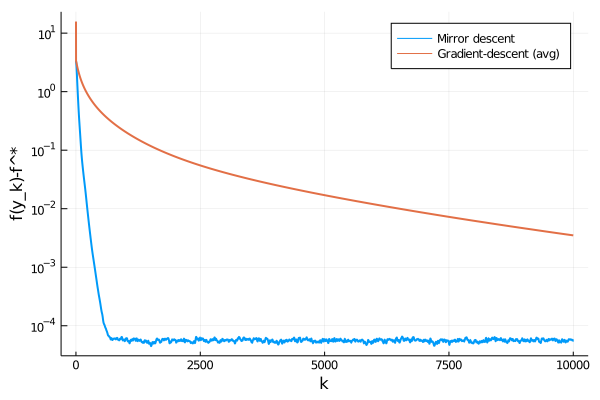

In [13]:
using Acceleration
using LinearAlgebra
using Plots

m = 100;
n = 75;

f,∇f,∇ϕ_cjg,σ,L,μ  = rand_psd(m,n);

k = 10000
x_ini = zeros(n)
ω = 0;

function exact_gradient(x)
    return ∇f(x), 0
end

function noisy_gradient(x)
    n = size(x,1);
    ξ = 0.1; 
    noise = randn(n);
    noise = noise / norm(noise,2);
    noise = noise*ξ;
    return (∇f(x) + noise), ξ;
end

function noisy_gradient2(x)
    n = size(x,1);
    ξ = 1; 
    noise = randn(n);
    noise = noise / norm(noise,2);
    noise = noise*ξ;
    return (∇f(x) + noise), ξ;
end

p3 = zeros(k)
p6 = zeros(k)

    @time f_opt = f(rand_psd_compute_optval(f,n));#ufom(f,exact_gradient,∇ϕ_cjg,x_ini,σ,L,μ,10*k,Inf,false)[end]
    grad_fun = noisy_gradient

for j=1:10

    @time p3 = (1-1/j).*p3 .+ (1/j).*(ufom(f,noisy_gradient,∇ϕ_cjg,x_ini,σ,L,μ,k,Inf) .- f_opt);
    @time p6 = (1-1/j).*p6 .+ (1/j).*(ACGD(f,noisy_gradient,x_ini,L,k,ω) .- f_opt);
        
end


fig = plot(max.(min.(hcat(p3,p6),1e3),1e-12),yaxis=:log, linewidth=2, legend=:topright,label = ["Mirror descent" "Gradient-descent (avg)" "New Algorithm" "AMD+ (ICML 2018)" "μAMD+ (ICML 2018)" "ACGD (ICML 2020)" "μACGD (ICML 2020)" "Nesterov 83"], xlabel = "k", ylabel = "f(y_k)-f^*")